In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import fiona
from rasterio.warp import reproject, Resampling
from rasterio.mask import mask
from rasterio.plot import show
from shapely.geometry import Polygon
%matplotlib inline

In [2]:
src =rasterio.open('/run/media/cparr/GINA/surfaces/tuolmne/TB20140407_SUPERsnow_depth_masked_MANUAL.tif')
src.meta

{'count': 1,
 'crs': CRS({'init': 'epsg:32611'}),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 16780,
 'nodata': None,
 'transform': Affine(3.0, 0.0, 254247.0,
       0.0, -3.0, 4229667.0),
 'width': 17699}

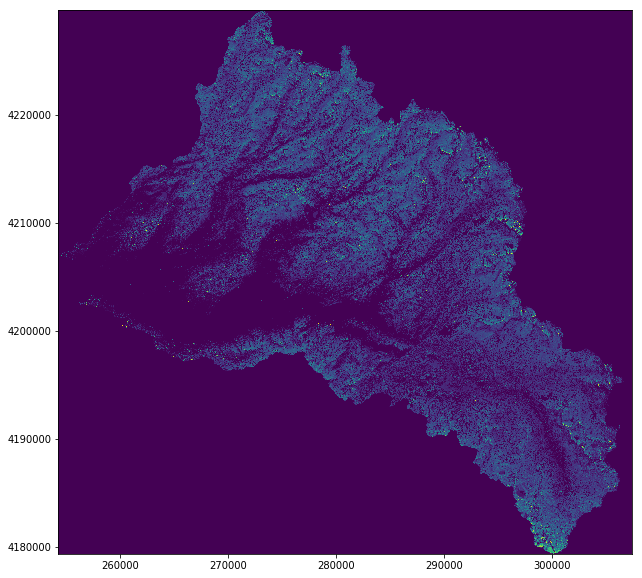

In [34]:
plt.figure(figsize=(16, 10))
show(src)

In [20]:
def crop_and_test(src, center, size, title):
    
    center_x = center[0]
    center_y = center[1]
    
    poly = Polygon([(center_x-(size / 2), center_y-(size / 2)),
           (center_x-(size / 2), center_y+(size / 2)),
           (center_x+(size / 2), center_y+(size / 2)),
           (center_x+(size / 2), center_y-(size / 2)),
           (center_x-(size / 2), center_y-(size / 2))])
    
    geom = [p for p in poly.boundary.coords]
    cropper = [{'coordinates': [geom],
              'type': 'Polygon'}]
    
    out_image, out_transform = mask(src, cropper, crop=True)
    out_meta = src.meta.copy()
    
    mu = np.nanmean(out_image.data[0])
    sigma = np.nanstd(out_image.data[0])
    dmin = np.nanmin(out_image.data[0])
    dmax = np.nanmax(out_image.data[0])
    
    surface = out_image.data[0]
    
    thresh_vals = [1,5,10,15,20,25,30,35,40,45,50,
                   55,60,65,70,75,80,85,90,95,99]

    drift_areas = []
    not_drift_areas = []
    drift_means = []
    not_drift_means = []
    drift_masses = []
    not_drift_masses = []
    drift_masses_pct = []
    not_drift_masses_pct = []
    area_check = []
    mass_check = []
    drifts_important = []

    for threshold in thresh_vals:

        threshold = (threshold / 100) * surface.max()
        drift_mask = surface > threshold
        not_drift_mask = surface <= threshold

        #drift_area = drift_mask.sum()
        #not_drift_area = not_drift_mask.sum()
        
        drift_area = (drift_mask.sum() / surface.size) * 100
        not_drift_area = (not_drift_mask.sum() / surface.size) * 100

        drift_mean = (np.sum(drift_mask * surface)) / drift_mask.sum()
        not_drift_mean = (np.sum(not_drift_mask * surface)) / not_drift_mask.sum()

        drift_mass = drift_mean * drift_area
        not_drift_mass = not_drift_mean * not_drift_area
        
        drift_mass_pct = (drift_mass / (drift_mass + not_drift_mass)) * 100
        not_drift_mass_pct = 100 - drift_mass_pct

        drift_areas.append(drift_area)
        not_drift_areas.append(not_drift_area)
        drift_means.append(drift_mean)
        not_drift_means.append(not_drift_mean)
        drift_masses.append(drift_mass)
        not_drift_masses.append(not_drift_mass)
        drift_masses_pct.append(drift_mass_pct)
        not_drift_masses_pct.append(not_drift_mass_pct)
        
    for a, b in zip(drift_areas, not_drift_areas):
        area_check.append(a < b)
        
    for a, b in zip(drift_masses_pct, not_drift_masses_pct):
        mass_check.append(a > b)
        
    for a, b in zip(area_check, mass_check):
        drifts_important.append(a and b)
    
    drifts_important = drifts_important*1
    
    fig = plt.figure(figsize = (16,10))
    ax = fig.add_subplot(111)
    im = plt.imshow(out_image.data[0], vmin = 0, vmax = dmax)
    ax.set_title(title +'\n'+
                 "$\mu=%.2f$, $\sigma=%.2f$"  %(mu,sigma))
    fig.colorbar(im)
    
    plt.figure(figsize=(8,5))
    plt.plot(thresh_vals, drift_areas, '-ro', label = 'Drift Area')
    plt.plot(thresh_vals, not_drift_areas, '-bo', label = 'Not Drift Area')
    plt.xlabel('Threshold (% of max)')
    plt.ylabel('% Area')
    plt.legend()
    
    plt.figure(figsize=(8,5))
    plt.axhline(y=surface.mean(), color='g', alpha=0.5, label = 'Total Mean')
    plt.plot(thresh_vals, drift_means, '-ro', label = 'Drift Mean')
    plt.plot(thresh_vals, not_drift_means, '-bo', label = 'Not Drift Mean')
    plt.xlabel('Threshold (% of max)')
    plt.ylabel('Depth [m]')
    plt.legend()
    
    plt.figure(figsize=(8,5))
    plt.plot(thresh_vals, drift_masses_pct, '-ro', label = 'Drift Mass')
    plt.plot(thresh_vals, not_drift_masses_pct, '-bo', label = 'Not Drift Mass')
    plt.xlabel('Threshold (% of max)')
    plt.ylabel('% Snow Mass')
    plt.legend()
    
    plt.figure(figsize=(8,5))
    plt.plot(thresh_vals, drift_areas, '-rx', label = 'Drift Area')
    plt.plot(thresh_vals, not_drift_areas, '-bx', label = 'Not Drift Area')
    plt.plot(thresh_vals, drift_masses_pct, '-ro', label = 'Drift Mass')
    plt.plot(thresh_vals, not_drift_masses_pct, '-bo', label = 'Not Drift Mass')
    plt.xlabel('Threshold (% of max)')
    plt.ylabel('%')
    plt.legend()
    
    plt.figure(figsize=(8,5))
    plt.plot(thresh_vals, drifts_important, '-g', label = 'Drifts are Important?')
    plt.xlabel('Threshold (% of max)')
    plt.legend()
    
    #
    #return drifts_important


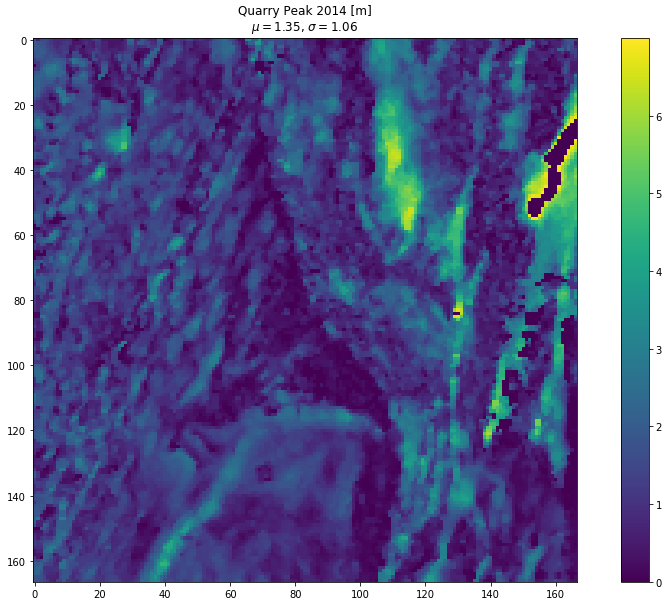

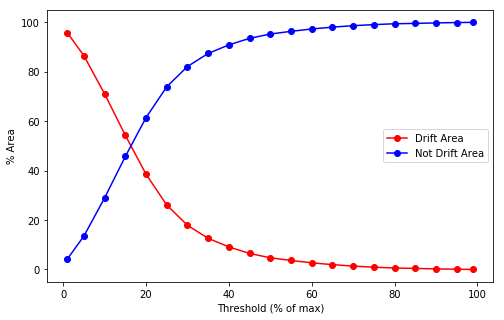

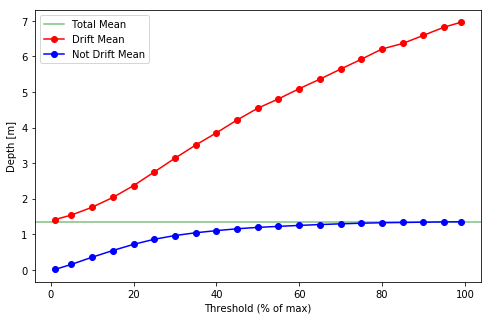

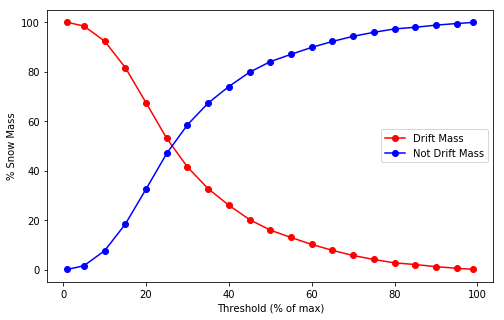

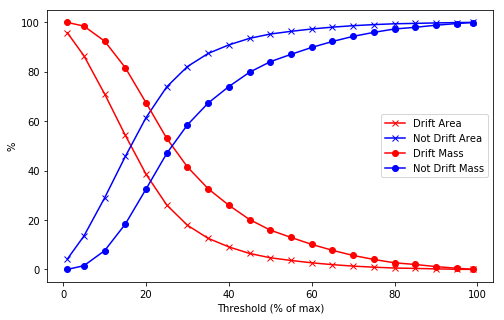

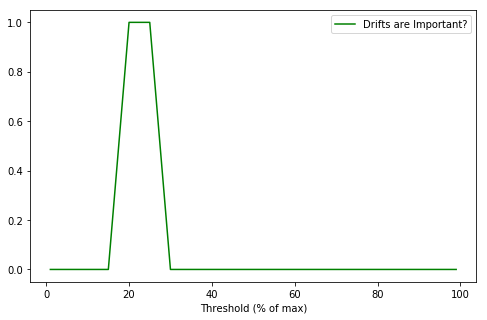

In [28]:
quarry_pk = (287710, 4213568)
crop_and_test(center=quarry_pk,size=500,src=src,title='Quarry Peak 2014 [m]')

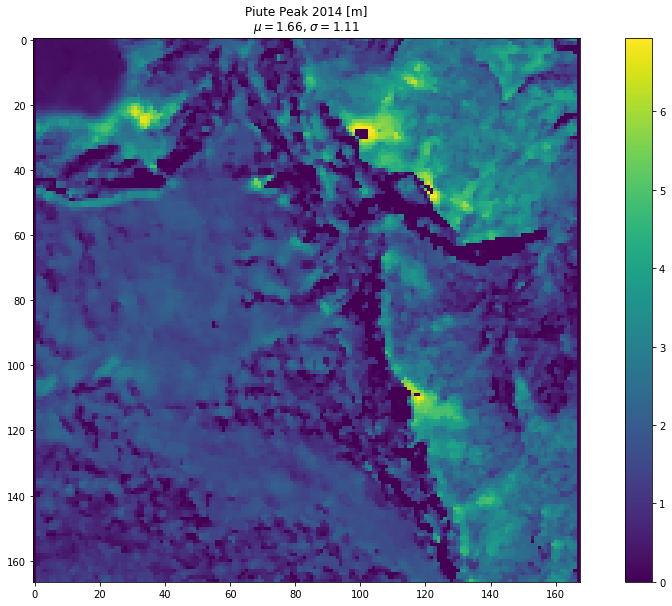

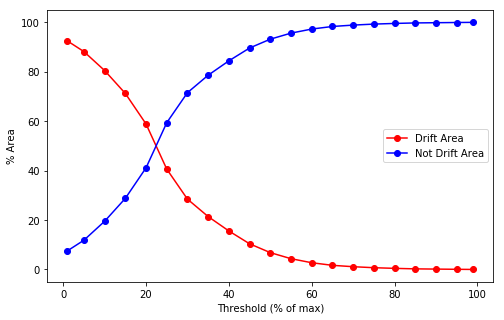

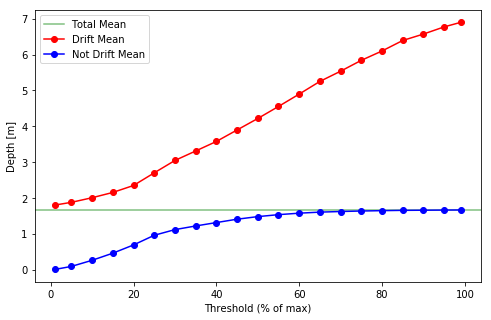

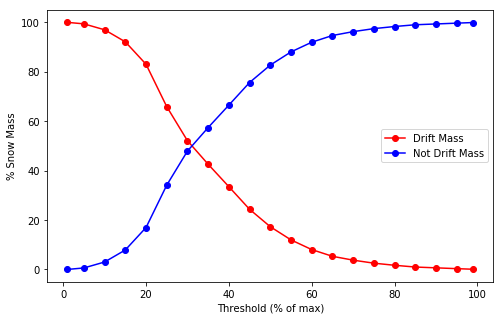

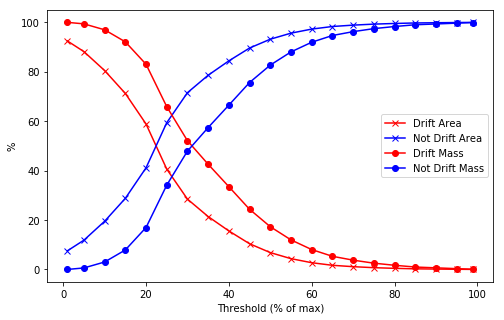

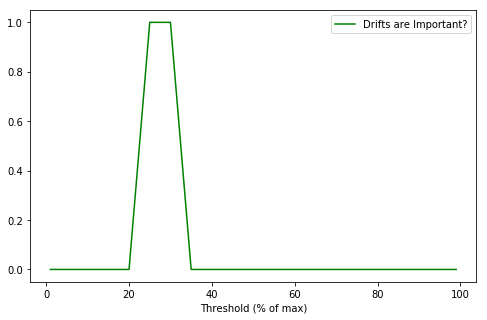

In [29]:
piute_pk = (276378, 4212599)
crop_and_test(center=piute_pk,size=500,src=src,title='Piute Peak 2014 [m]')

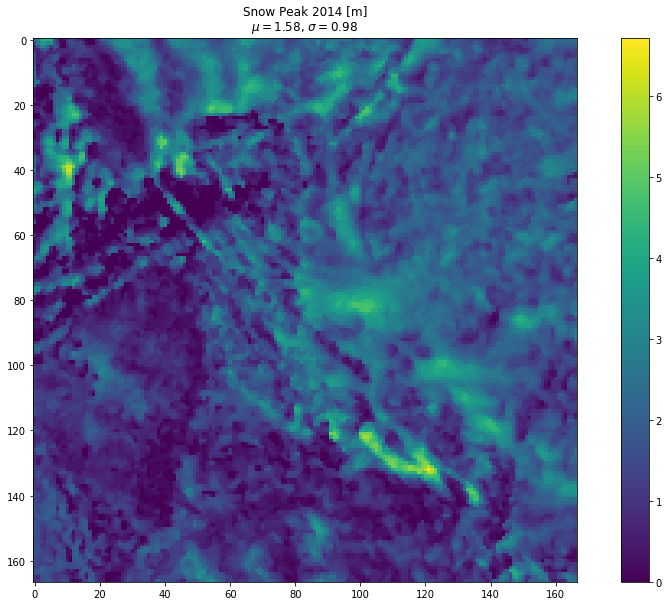

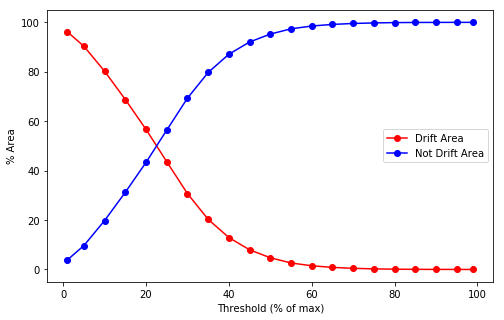

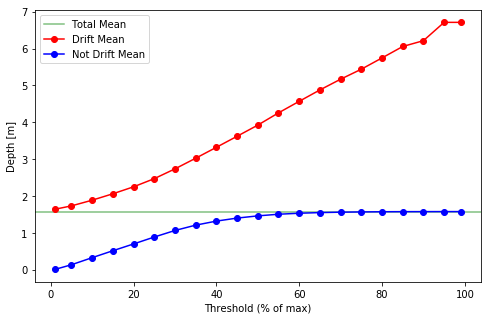

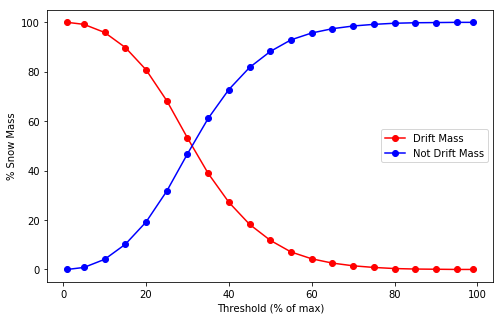

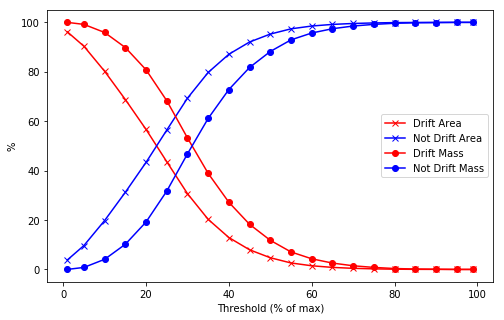

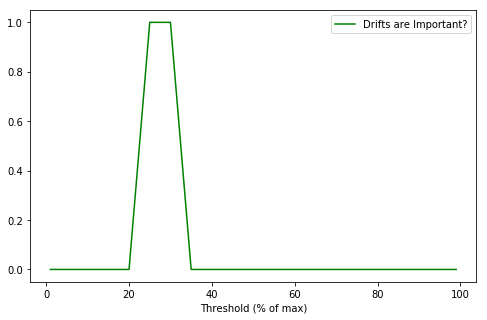

In [30]:
snow_pk = (274670, 4221784)
crop_and_test(center=snow_pk,size=500,src=src,title='Snow Peak 2014 [m]')

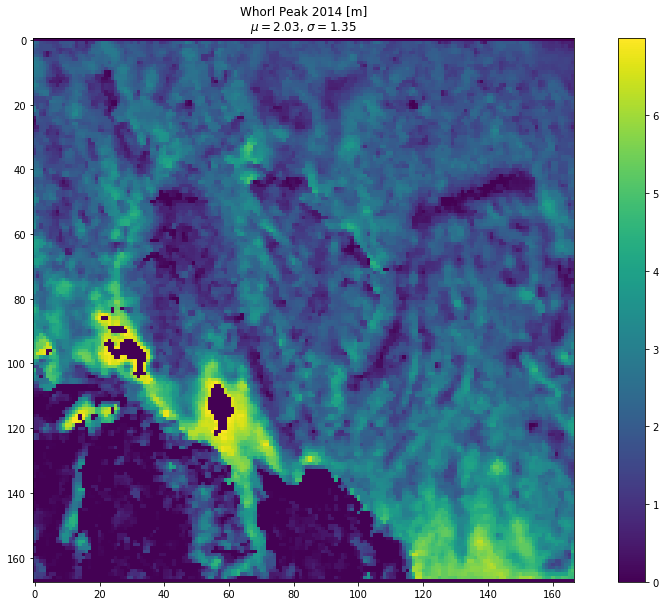

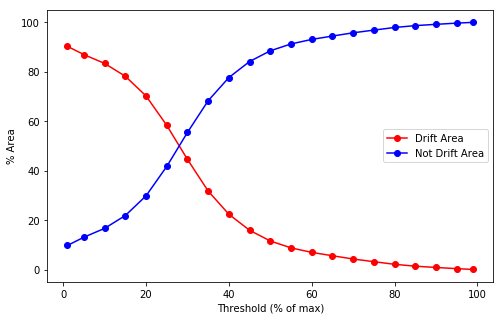

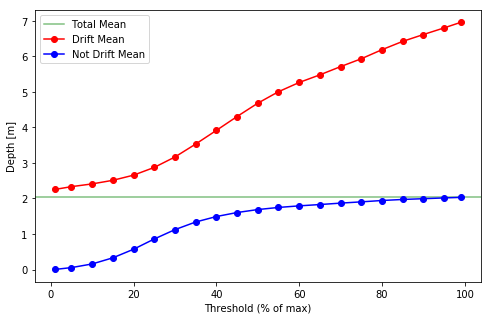

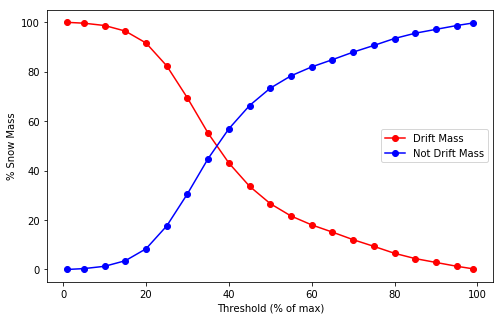

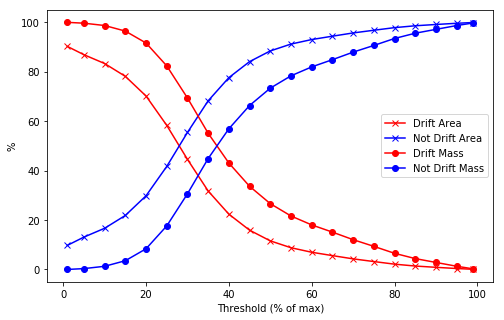

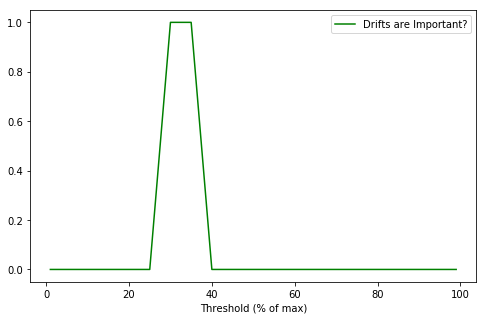

In [31]:
whorl_pk = (290000, 4216713)
crop_and_test(center=whorl_pk,size=500,src=src,title='Whorl Peak 2014 [m]')

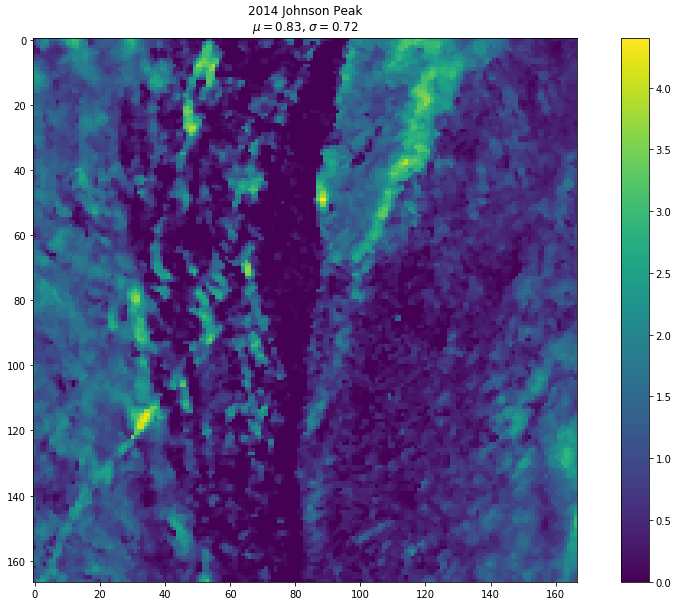

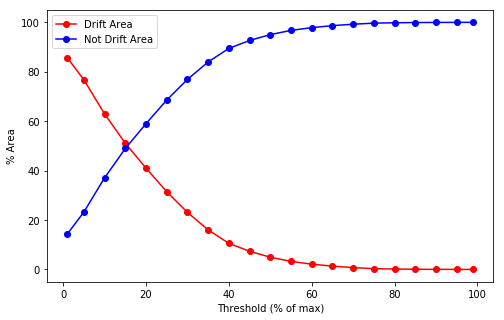

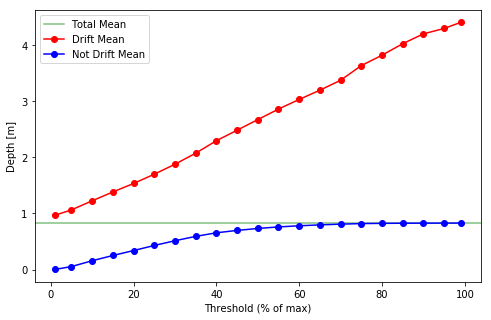

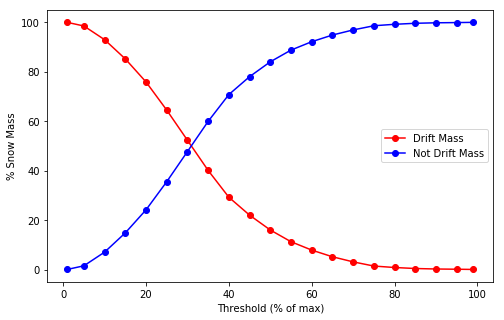

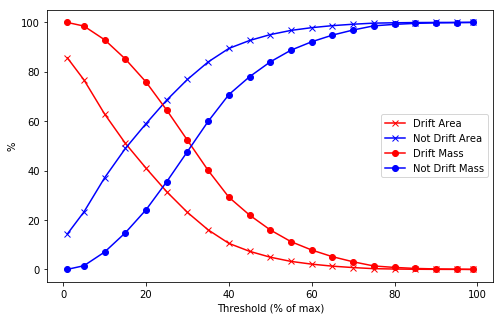

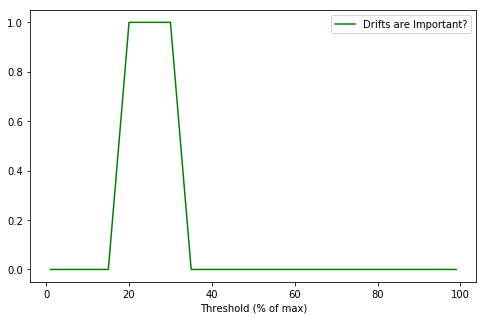

In [32]:
johnson_pk = (293293, 4190108)
crop_and_test(center=johnson_pk,size=500,src=src,title='2014 Johnson Peak')

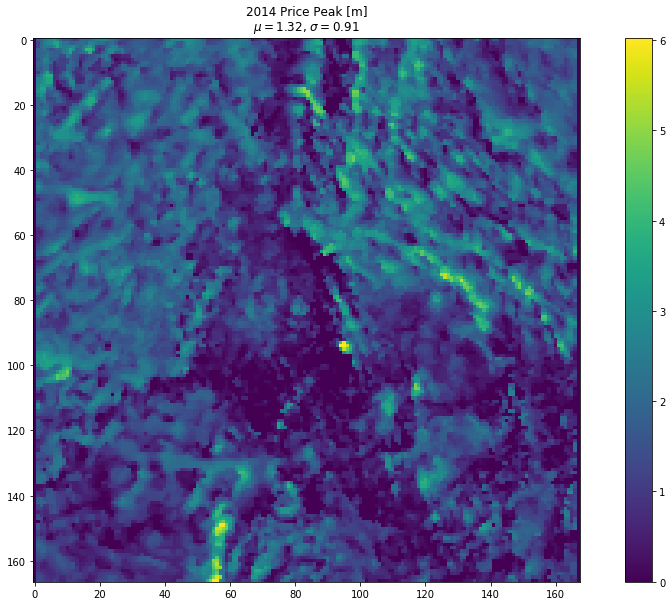

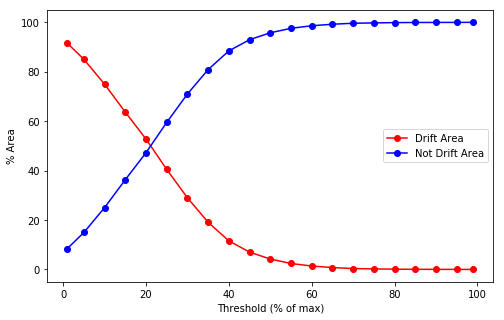

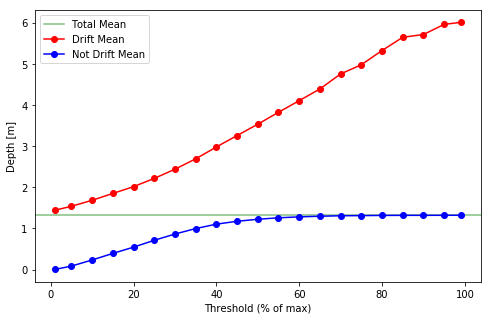

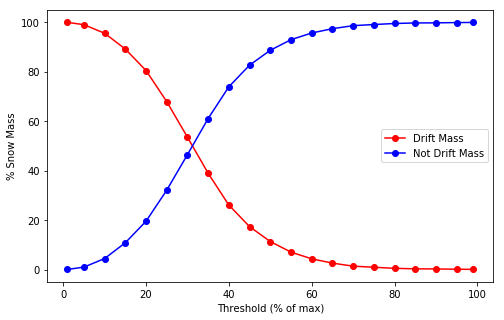

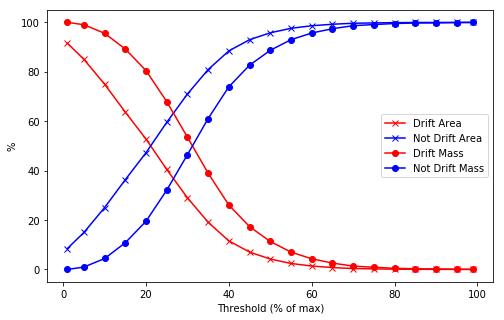

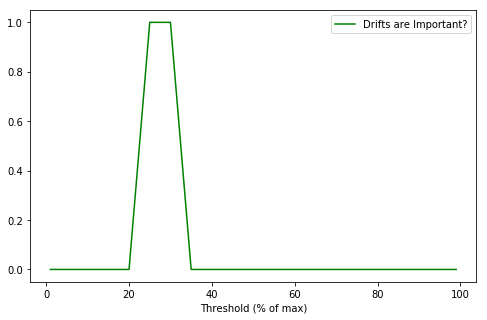

In [33]:
price_pk = (277980, 4216010)
crop_and_test(center=price_pk,size=500,src=src,title='2014 Price Peak [m]')

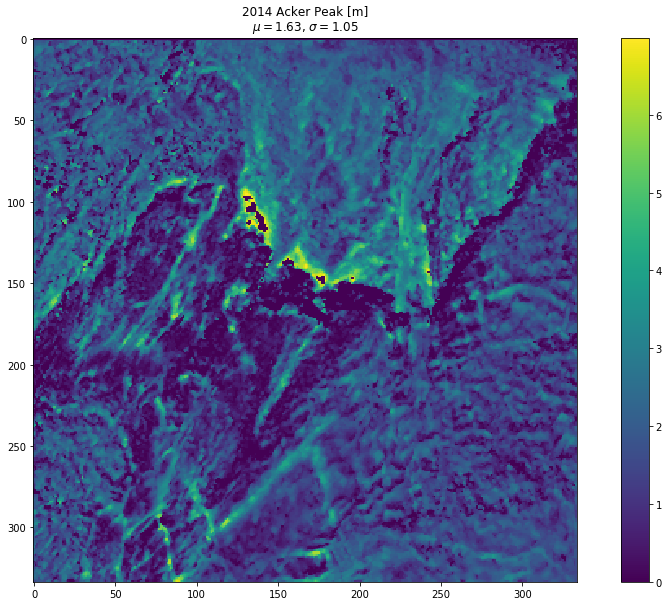

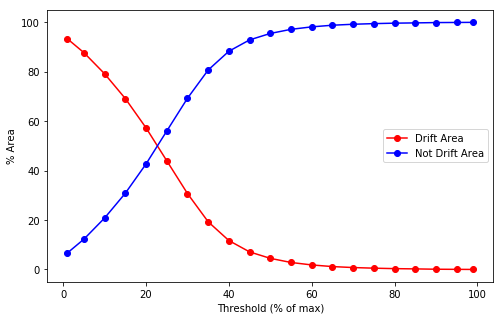

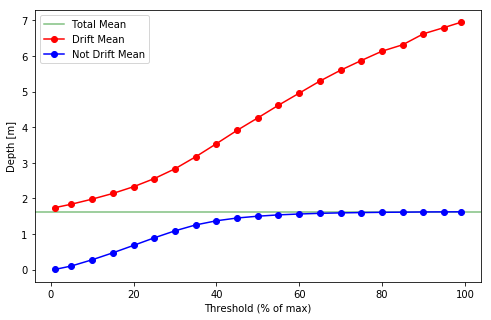

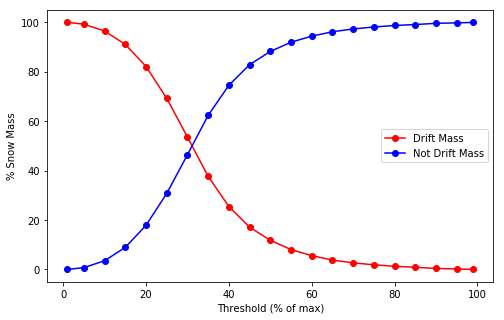

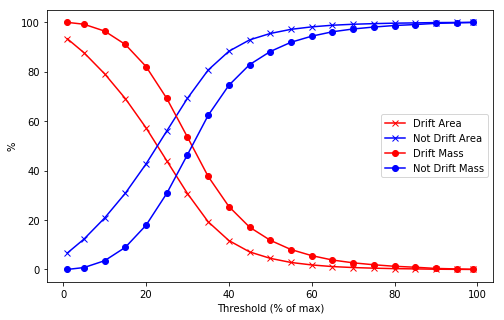

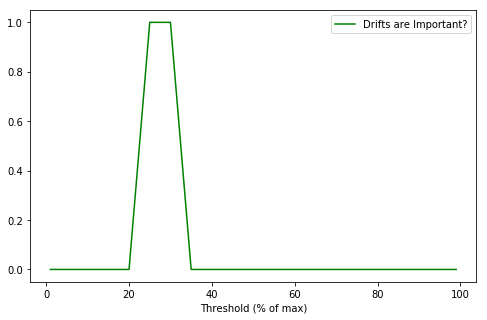

In [49]:
acker = (279990, 4220930)
crop_and_test(center=acker,size=1000,src=src,title='2014 Acker Peak [m]')

In [45]:
tuolumne = (round((src.bounds.left+src.bounds.right)/2)),(round((src.bounds.bottom+src.bounds.top)/2))
tuolumne

(280796, 4204497)